# Прогноз цен на карбамид и аммиак 2021-2050

Импортируем необходимые для анализа и визуализации библиотеки

In [254]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from matplotlib.lines import Line2D

Cчитаем excel файл, прикрепеленный в приложении

In [3]:
data = pd.read_excel('Kearney_case.xlsx')
data = data[:-1]

Переформатируем столбец с цен на природный газ, чтобы в не остались только значения

In [4]:
data['LNG price'] = data['LNG price'].apply(lambda x: float(x.split(',')[1]))

In [5]:
data

,Date,LNG price,Oil price,Urea price
0,Jan 1997,5.43,24.15,173.50
1,Feb 1997,2.95,20.30,160.38
2,Mar 1997,3.05,20.41,148.00
3,Apr 1997,3.57,20.21,135.00
4,May 1997,3.69,20.88,113.13
...,...,...,...,...
284,Sep 2020,1.69,40.22,250.50
285,Oct 2020,3.08,35.79,245.00
286,Nov 2020,2.94,45.34,245.00
287,Dec 2020,2.40,48.52,245.00


На диаграмме рассеяния покажем зависимость между ценой на нефть и ценой на карбамид (1997 - 2021 гг.)

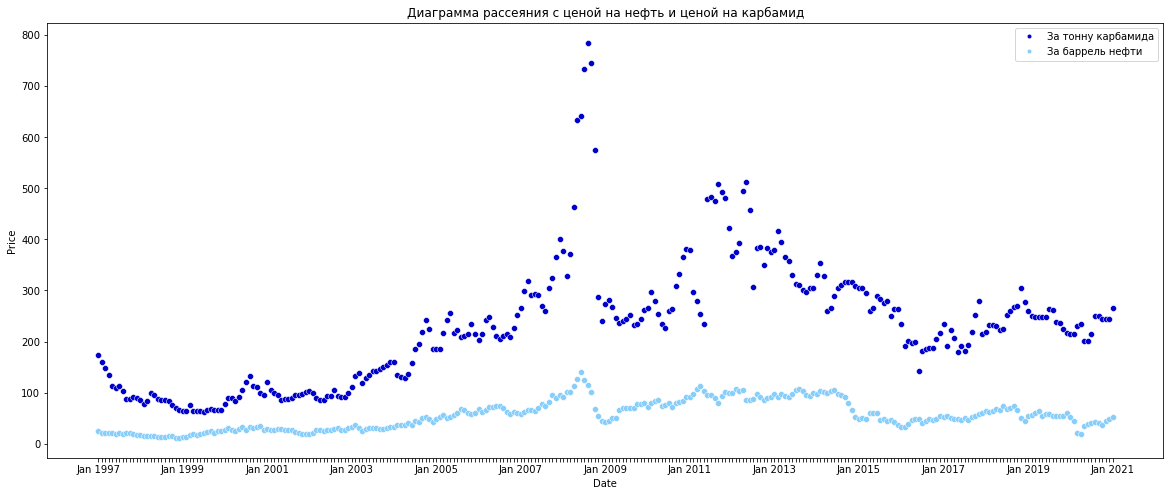

In [6]:
fig, ax = plt.subplots(figsize=(20, 8))
plt.title('Диаграмма рассеяния с ценой на нефть и ценой на карбамид')
sns.scatterplot(x='Date', y='Urea price',  data=data, color='mediumblue')
sns.scatterplot(x='Date', y='Oil price',  data=data, color='lightskyblue')

every_nth = 24
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

plt.xlabel('Date')
plt.ylabel('Price')
custom = [Line2D([], [], marker='.', color='mediumblue', linestyle='None'),
          Line2D([], [], marker='.', color='lightskyblue', linestyle='None')]
plt.legend(custom, ['За тонну карбамида', 'За баррель нефти'], loc='upper right')

plt.show()

Удалим столбец-признак "Дата", чтобы он не влиял на обучение модели

In [7]:
data = data.drop('Date', axis=1)
data

,LNG price,Oil price,Urea price
0,5.43,24.15,173.50
1,2.95,20.30,160.38
2,3.05,20.41,148.00
3,3.57,20.21,135.00
4,3.69,20.88,113.13
...,...,...,...
284,1.69,40.22,250.50
285,3.08,35.79,245.00
286,2.94,45.34,245.00
287,2.40,48.52,245.00


Покажем на матрице корреляций зависимость между признаками

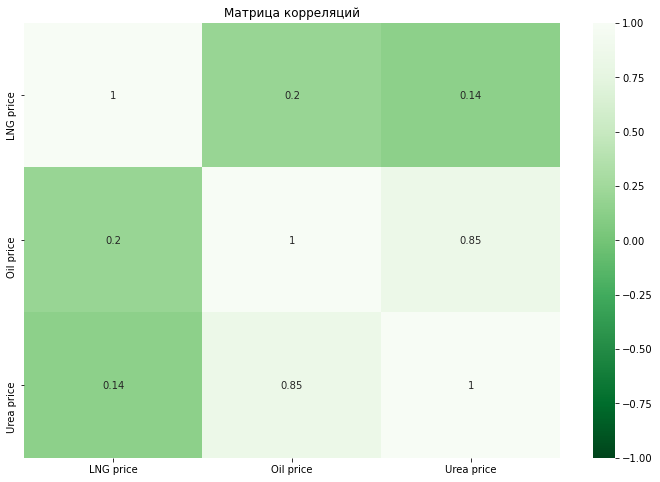

In [8]:
plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True, cmap='Greens_r')
heatmap.set_title('Матрица корреляций');

Введем матрицу объект-признак X и целевую переменную y

In [9]:
y = data['Urea price']
X = data[['LNG price', 'Oil price']]

Разделим выборку на обучающую и тестовую и нормализуем признаки

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=21)

normalizer = preprocessing.StandardScaler()

X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)

Обучим модель и посчитаем MSE и R-square для полученных коэффициентов

In [11]:
reg = HuberRegressor().fit(X_train, y_train)

y_pred_train = reg.predict(X_train) 
y_pred_test = reg.predict(X_test)

print('R-square:', reg.score(X_train, y_train))
print('MSE на трейне', mean_squared_error(y_train, y_pred_train))
print('MSE на тесте', mean_squared_error(y_test, y_pred_test))

R-square: 0.7182803675891314
MSE на трейне 4444.424852769651
MSE на тесте 3770.9891040941184


In [12]:
reg_norm = HuberRegressor().fit(X_train_norm, y_train)

y_pred_train = reg_norm.predict(X_train_norm) 
y_pred_test = reg_norm.predict(X_test_norm)

print('R-square:', reg_norm.score(X_train_norm, y_train))
print('MSE на трейне', mean_squared_error(y_train, y_pred_train))
print('MSE на тесте', mean_squared_error(y_test, y_pred_test))

R-square: 0.7182776294070957
MSE на трейне 4444.468050484296
MSE на тесте 3770.9828817736484


Коэффициенты, полученные в модели

In [13]:
dict(zip(X.columns, reg.coef_)), reg.intercept_

({'LNG price': -2.494276121849734, 'Oil price': 3.5418970005013017},
 39.40676084541214)

In [14]:
LNG_coef = reg.coef_[0]
Oil_coef = reg.coef_[1]

In [15]:
dict(zip(X.columns, reg_norm.coef_)), reg_norm.intercept_

({'LNG price': -7.675047677270762, 'Oil price': 102.57123600963668},
 224.35632998632624)

Зафиксируем временной горизонт прогноза: 2021 - 2051

In [16]:
forecast_horizon = np.arange(2021, 2051, 1)

Зафиксируем прогноз на 5 лет, приведенный в кейсе (2021 - 2025 гг.)

In [17]:
case_forecast_urea = np.array([218, 235, 254, 263, 278])
case_forecast_ammonia = np.array([221, 248, 237, 261, 264])

Выведем вектор цен (прогнозов) для базового сценария (предельная цена на нефть = 65)

In [18]:
np.random.seed(12265)

In [19]:
base_trace = []
base_current = case_forecast_urea[-1] 

base_limit = 65 * Oil_coef + LNG_coef * 3 + reg.intercept_
for year in range(2026, 2051):
    base_current = base_current + np.random.uniform(-0.2, 0.5) * (base_limit - base_current)
    base_trace.append(base_current)

In [20]:
base_ammonia = np.append(case_forecast_ammonia, base_trace + np.random.uniform(-7, 7, 25))
base_ammonia

array([221.        , 248.        , 237.        , 261.        ,
       264.        , 273.97151153, 286.32631762, 280.6417352 ,
       270.16935753, 265.57213547, 271.78078013, 264.91289493,
       258.31075227, 266.93082553, 261.75189536, 268.9382487 ,
       260.4573829 , 256.49009694, 262.61311706, 256.64303014,
       261.76673733, 268.13572672, 261.2770463 , 265.20462454,
       259.26488809, 260.14645964, 259.86483566, 255.23518201,
       265.64897274, 264.3895707 ])

In [21]:
base_scenario_urea = np.append(case_forecast_urea, base_trace)
base_scenario_urea

array([218.        , 235.        , 254.        , 263.        ,
       278.        , 279.64814951, 279.53790797, 281.86597896,
       273.58494432, 270.50180928, 266.78633119, 266.07390629,
       264.12681648, 263.3993384 , 262.84878981, 262.50346589,
       262.50116781, 262.51522241, 262.52700891, 262.34391643,
       262.29595784, 262.22465623, 262.21855725, 262.20817822,
       262.21938421, 262.22884529, 262.20380384, 262.1966217 ,
       262.17822595, 262.16677595])

Выведем вектор цен (прогнозов) для хорошего сценария (предельная цена на нефть = 85)

In [22]:
good_trace = []
good_current = case_forecast_urea[-1] 

good_limit = 85 * Oil_coef + LNG_coef * 3 + reg.intercept_
  
for year in range(2026, 2051):
    good_current = good_current + np.random.uniform(-0.2, 0.5) * (good_limit - good_current)
    good_trace.append(good_current)

In [23]:
good_ammonia = np.append(case_forecast_ammonia, good_trace + np.random.uniform(-7, 7, 25))
good_ammonia

array([221.        , 248.        , 237.        , 261.        ,
       264.        , 286.01125095, 284.56020895, 278.97680789,
       271.96582022, 283.03953828, 278.88025164, 281.7681363 ,
       293.76916813, 289.05527554, 309.35124901, 311.15190776,
       314.11007679, 314.92854101, 322.81542959, 321.27658721,
       322.48257871, 323.67680409, 330.37569511, 329.43411688,
       327.52420035, 335.75469611, 330.74929013, 325.01137203,
       332.2961975 , 334.66837364])

In [24]:
good_scenario_urea = np.append(case_forecast_urea, good_trace)
good_scenario_urea

array([218.        , 235.        , 254.        , 263.        ,
       278.        , 292.21978233, 285.87181833, 282.4268396 ,
       276.00562606, 278.03477576, 280.76582968, 287.24034172,
       291.34314592, 287.73957364, 306.36471289, 312.27759259,
       321.01422809, 320.00418643, 317.70197941, 319.1930437 ,
       323.81186334, 323.26148048, 326.98344044, 329.90818159,
       330.13185572, 329.7640321 , 330.88540024, 331.79787198,
       332.2003784 , 332.57525322])

Выведем вектор цен (прогнозов) для плохого сценария (предельная цена на нефть = 45)

In [25]:
bad_trace = []
bad_current = case_forecast_urea[-1] 

bad_limit = 45 * Oil_coef + LNG_coef * 3 + reg.intercept_
for year in range(2026, 2051):
    bad_current = bad_current + np.random.uniform(-0.2, 0.5) * (bad_limit - bad_current)
    bad_trace.append(bad_current)

In [26]:
bad_ammonia = np.append(case_forecast_ammonia, bad_trace + np.random.uniform(-7, 7, 25))
bad_ammonia

array([221.        , 248.        , 237.        , 261.        ,
       264.        , 298.52969104, 242.65977284, 215.8813401 ,
       221.34131152, 202.38374243, 198.34263721, 197.29877453,
       195.40865821, 204.92801739, 203.08023409, 197.94089651,
       203.57799274, 204.53594957, 196.90400337, 200.69483245,
       193.97943612, 190.08768122, 197.20499874, 198.77910464,
       187.63710549, 187.16946017, 194.28233808, 192.04255955,
       194.50370725, 192.50479961])

In [27]:
bad_scenario_urea = np.append(case_forecast_urea, bad_trace)
bad_scenario_urea

array([218.        , 235.        , 254.        , 263.        ,
       278.        , 291.75731999, 246.14964255, 221.40413665,
       217.0634101 , 206.63188914, 204.23644834, 200.73717263,
       201.73726808, 203.51143034, 204.91111946, 201.0847376 ,
       198.06549674, 198.66109906, 196.33470124, 196.02994039,
       195.25568465, 193.69238529, 193.99690627, 192.9691576 ,
       192.70213469, 192.72608201, 192.90719985, 193.0430966 ,
       193.19411369, 192.58503238])

Зафиксируем полученные прогнозы для трех сценариев (это необходимо, так как при прогнозе учитывалась волатильность на цен на нефть в виде равномерно распределенной случайной величины)

Базовый сценарий:

In [390]:
base_scenario_urea = np.array([218.        , 235.        , 254.        , 263.        ,   # прогноз для карбамида
                               278.        , 275.6059039 , 275.31592038, 276.57790616,
                               272.52155349, 270.3626718 , 269.8121194 , 269.56381579,
                               268.83409369, 268.96910848, 268.85824445, 268.52889311,
                               268.45864985, 268.44751354, 268.52599242, 268.54811671,
                               268.53174791, 268.62606668, 268.6614404 , 268.70210139,
                               268.53128398, 268.61781508, 268.54535547, 268.56156785,
                               268.5238453 , 268.35539337])

base_ammonia = np.array([221.        , 248.        , 237.        , 261.        ,   # прогноз для аммония
                         264.        , 277.09440209, 277.79877073, 270.03003461,
                         272.14098728, 272.30507846, 268.58563433, 271.19774752,
                         264.24696409, 265.53963096, 269.90152402, 262.84012581,
                         264.61090746, 266.99871752, 268.78913421, 270.24692418,
                         262.25273063, 268.15065218, 270.63518498, 264.96130821,
                         270.5030004 , 261.68566371, 275.47359703, 267.94894168,
                         268.9568667 , 270.60062625])

Положительный сценарий:

In [391]:
good_scenario_urea = np.array([218.        , 235.        , 254.        , 263.        ,   # прогноз для карбамида
                               278.        , 269.41218753, 305.02069118, 308.31897729,
                               307.61560341, 304.28179782, 319.42602367, 321.51719538,
                               318.60940407, 326.30325012, 327.8129268 , 334.58508401,
                               334.94766009, 333.85543985, 335.13821336, 334.18879266,
                               335.17461623, 338.29083328, 338.68995559, 339.73294624,
                               339.73848794, 339.84998559, 339.92662118, 339.4825378 ,
                               340.35159587, 340.82610129])


good_ammonia = np.array([221.        , 248.        , 237.        , 261.        ,   # прогноз для аммония
                         264.        , 274.39228403, 306.25176545, 313.27212954,
                         301.04356546, 300.10576635, 323.25986272, 322.0500665 ,
                         324.99797129, 325.91138308, 322.11340017, 330.68684739,
                         332.43461876, 335.88905624, 341.61896804, 340.2812589 ,
                         334.14418132, 337.91099755, 333.86125554, 339.69786993,
                         336.91907263, 343.49684372, 336.80313603, 334.24682162,
                         343.39211353, 340.75040752])

Негативный сценарий

In [392]:
bad_scenario_urea = np.array([218.        , 235.        , 254.        , 263.        ,   # прогноз для карбамида
                              278.        , 256.19456398, 265.92889884, 271.21162832,
                              281.05828826, 277.94667283, 273.75871692, 263.83032599,
                              257.53884892, 263.06477491, 234.50390998, 225.43675853,
                              212.03949675, 213.58835299, 217.1186903 , 214.83220613,
                              207.74944117, 208.59343006, 202.88596155, 198.40099444,
                              198.0579996 , 198.6220416 , 196.90247088, 195.50323398,
                              194.88600738, 194.31115267])

bad_ammonia = np.array([221.        , 248.        , 237.        , 261.        ,   # прогноз для аммония
                        264.        , 259.64382818, 270.80900948, 267.53412179,
                        283.7856738 , 277.52240716, 271.11158921, 269.17767675,
                        255.19418848, 260.49136102, 240.42058445, 226.08038889,
                        213.71469353, 218.19979376, 215.04671904, 219.8022318 ,
                        203.77395596, 211.01096475, 201.99998562, 201.93759223,
                        195.20309696, 195.25509029, 201.47062835, 194.6682395 ,
                        196.20326045, 195.64105875])

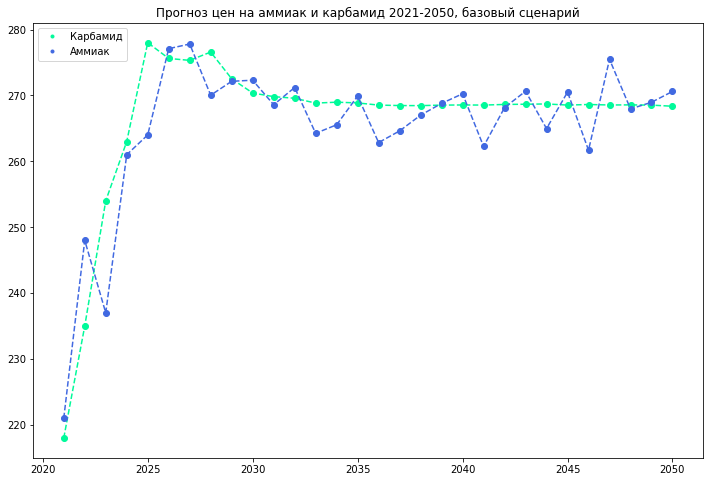

In [31]:
xs = forecast_horizon
ys = base_scenario_urea
yss = base_ammonia
plt.figure(figsize=(12, 8))
plt.title('Прогноз цен на аммиак и карбамид 2021-2050, базовый сценарий')

plt.plot(xs, ys, linestyle='--', marker='o', color='mediumspringgreen')
plt.plot(xs, yss, linestyle='--', marker='o', color='royalblue')
custom = [Line2D([], [], marker='.', color='mediumspringgreen', linestyle='None'),
          Line2D([], [], marker='.', color='royalblue', linestyle='None')]
plt.legend(custom, ['Карбамид', 'Аммиак'], loc='upper left');

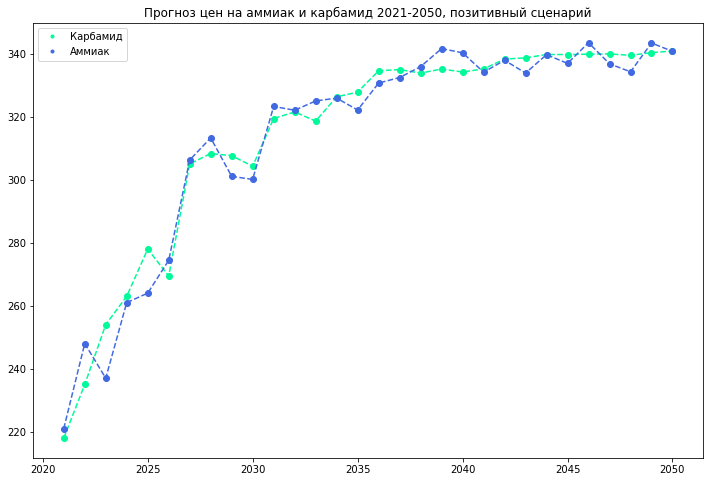

In [32]:
xs = forecast_horizon
ys = good_scenario_urea
yss = good_ammonia
plt.figure(figsize=(12, 8))
plt.title('Прогноз цен на аммиак и карбамид 2021-2050, позитивный сценарий')

plt.plot(xs, ys, linestyle='--', marker='o', color='mediumspringgreen')
plt.plot(xs, yss, linestyle='--', marker='o', color='royalblue')
custom = [Line2D([], [], marker='.', color='mediumspringgreen', linestyle='None'),
          Line2D([], [], marker='.', color='royalblue', linestyle='None')]
plt.legend(custom, ['Карбамид', 'Аммиак'], loc='upper left');

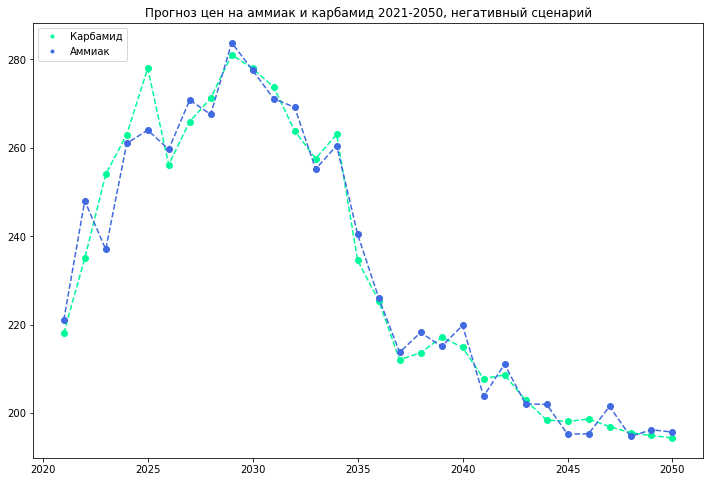

In [33]:
xs = forecast_horizon
ys = bad_scenario_urea
yss = bad_ammonia
plt.figure(figsize=(12, 8))
plt.title('Прогноз цен на аммиак и карбамид 2021-2050, негативный сценарий')

plt.plot(xs, ys, linestyle='--', marker='o', color='mediumspringgreen')
plt.plot(xs, yss, linestyle='--', marker='o', color='royalblue')
custom = [Line2D([], [], marker='.', color='mediumspringgreen', linestyle='None'),
          Line2D([], [], marker='.', color='royalblue', linestyle='None')]
plt.legend(custom, ['Карбамид', 'Аммиак'], loc='upper left');

# Прогноз цен по регионам: Азия, Северная Америка, Европа, Латинская Америка

In [393]:
data = pd.read_excel('Kearney_case.xlsx')

Выведем мировые цены на карбамид в январе 2021

In [394]:
world_price = float(data[data['Date'] == 'Jan 2021']['Urea price'])
world_price

265.0

Выведем цены на карбамид в азиатском, северо-американском, латино-американском, европейском регионах в январе 2021 

In [395]:
Asia_price = 316
North_Am_price = 278
Europe_price = 270
Latin_Am_price = 350

Посчитаем отклонение цен на карбамид в отдельном регионе от мировых в январе 2021

In [396]:
Asia_deviation = 1 + (Asia_price - world_price) / world_price
North_Am_deviation = 1 + (North_Am_price - world_price) / world_price 
Europe_deviation = 1 + (Europe_price - world_price) / world_price
Latin_Am_deviation = 1 + (Latin_Am_price - world_price) / world_price

__Выведем прогноз цен по регионам на карбамид__

При базовом сценарии

In [397]:
Asia_urea_base = Asia_deviation * base_scenario_urea
North_Am_urea_base = North_Am_deviation * base_scenario_urea
Europe_urea_base = Europe_deviation * base_scenario_urea
Latin_Am_urea_base = Latin_Am_deviation * base_scenario_urea

При положительном сценарии

In [398]:
Asia_urea_good = Asia_deviation * good_scenario_urea
North_Am_urea_good = North_Am_deviation * good_scenario_urea
Europe_urea_good = Europe_deviation * good_scenario_urea
Latin_Am_urea_good = Latin_Am_deviation * good_scenario_urea

При негативном сценарии

In [399]:
Asia_urea_bad = Asia_deviation * bad_scenario_urea
North_Am_urea_bad = North_Am_deviation * bad_scenario_urea
Europe_urea_bad = Europe_deviation * bad_scenario_urea
Latin_Am_urea_bad = Latin_Am_deviation * bad_scenario_urea

# Прогноз цен по странам: 
Бразилия, Болгария, Чехия, Словакия, Греция, Румыния, Нидерланды, Сербия, Австрия, Бельгия, Швеция, Украина, Болгария, Казахстан, Индия, Мьянма, Бангладеш, Филиппины, Таиланд, Южная Корея, Япония, Вьетнам, ЮАР, Куба, Чили

Считаем файл с данными по ценам на карбамид в приведенных странах

In [590]:
df = pd.read_excel('countries_forecast.xlsx', index_col=False)

Транспонируем считанную матрицу

In [591]:
df = df.T

In [592]:
new_header = df.iloc[0]
df = df[1:] 
df.columns = new_header

In [593]:
df.columns

Index(['Мировые цены', 'Бразилия', 'Болгария', 'Чехии', 'Словакия', 'Греция',
       'Румыния', 'Нидерланды', 'Сербия', 'Австрия', 'Бельгия', 'Швеция',
       'Украина', 'Казахстан', 'иднии', 'Мьянма', 'бангладеш', 'Филиппины',
       'таиланд', 'Южная Корея', 'Япония', 'Вьетнам', 'США', 'Куба', 'Чилли',
       'ЮАР'],
      dtype='object', name='Date')

In [594]:
country_labels = ['World', 'Brazil', 'Bulgaria', 'Checz', 'Slovakia', 'Greece', 'Romania', 'Netherlands', 'Serbia', 'Austria', 'Belgium', 'Sweden', 'Ukraine', 'Kazakhstan', 'India', 'Myanmar', 'Bangladesh', 'Philippines', 'Thailand', 'Korea', 'Japan', 'Vietnam', 'USA', 'Cuba', 'Chilie', 'RSA']

In [595]:
df.columns = country_labels

In [596]:
df['World'] = df['World'].apply(lambda x: float(x))

In [597]:
country_dict = dict()

for col in df.columns[1:]:
    df[col] = df[col].astype(str)
    df[col] = np.where(df[col] == 'nan', 0, df[col])
    df[col] = df[col].apply(lambda x: float(x))
    
    label = '{}'.format(col)
    
    country_dict[col] = pd.DataFrame({label: df[col].to_list(), 'World': df['World'].to_list()})

In [836]:
regression_set = dict()
r_square_mse_set = dict()

for key in country_dict.keys():
    country_dict[key] = country_dict[key][country_dict[key][key] > 0]
    
    X = country_dict[key][key]
    X = np.array(X).reshape(-1,1)
    y = country_dict[key]['World']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=123)
    
    reg = LinearRegression().fit(X_train, y_train)
    y_pred_train = reg.predict(X_train) 
    y_pred_test = reg.predict(X_test)
    
    regression_set[key] = (reg.coef_[0] + 0.1, reg.intercept_ + 30)

In [837]:
regression_set

{'Brazil': (1.1016712054712428, 30.35091789610982),
 'Bulgaria': (0.978621229204538, 52.37216268625173),
 'Checz': (1.0576896989601556, 43.22354873092041),
 'Slovakia': (1.2045904043376332, 21.716221744122066),
 'Greece': (0.9871756267550833, 52.50155631491697),
 'Romania': (1.2016075245831552, 17.807362120564335),
 'Netherlands': (0.2555675346171371, 238.83186303639775),
 'Serbia': (1.293877551020408, -8.408163265306086),
 'Austria': (3.433333333333333, -442.66666666666663),
 'Belgium': (1.0723351519599136, 26.658800028559682),
 'Sweden': (0.8497858384120224, 61.80669163178891),
 'Ukraine': (0.9853685625141773, 48.00033276125501),
 'Kazakhstan': (0.6791138265299874, 76.65640842278924),
 'India': (0.953472632893094, 59.37104934621203),
 'Myanmar': (0.1, 220.0),
 'Bangladesh': (0.953472632893094, 59.37104934621203),
 'Philippines': (0.9999999999999998, 34.700000000000045),
 'Thailand': (0.1, 293.0),
 'Korea': (0.956109381412954, 50.21197623657292),
 'Japan': (0.5052570592181496, 168.254

In [838]:
predict_India = Asia_deviation
predict_Japan = Asia_deviation
predict_Bangladesh = Asia_deviation
predict_Myanmar = Asia_deviation
predict_Austria = Europe_deviation
predict_Kazakhstan = Europe_deviation
predict_Netherlands = Europe_deviation
predict_Thailand = Asia_deviation
predict_Turkey = Asia_deviation
predict_Cuba = Latin_Am_deviation

In [839]:
regression_set.pop('India', None)
regression_set.pop('Japan', None)
regression_set.pop('Bangladesh', None)
regression_set.pop('Myanmar', None)
regression_set.pop('Austria', None)
regression_set.pop('Kazakhstan', None)
regression_set.pop('Netherlands', None)
regression_set.pop('Thailand', None)
regression_set.pop('Turkey', None)
regression_set.pop('Cuba', None)

(2.3443365695792884, -339.12297734627833)

In [840]:
base_scenario = base_scenario_urea[4:]
good_scenario = good_scenario_urea[4:]
bad_scenario = bad_scenario_urea[4:]

In [841]:
base = []
good = []
bad = []

for key in regression_set.keys():
    base.append(regression_set[key][0] * base_scenario + regression_set[key][1])
    good.append(regression_set[key][0] * good_scenario + regression_set[key][1])
    bad.append(regression_set[key][0] * bad_scenario + regression_set[key][1])

In [842]:
countries_list = list(regression_set.keys())
countries_list = countries_list[1:]
for country in ['India', 'Japan', 'Bangladesh', 'Myanmar', 'Austria', 'Kazakhstan', 'Netherlands', 'Thailand', 'Turkey', 'Cuba']:
    countries_list.append(country)

In [843]:
for elem in [predict_India, predict_Japan, predict_Bangladesh, predict_Myanmar, predict_Austria , predict_Kazakhstan, predict_Netherlands, predict_Thailand, predict_Turkey]:
    base.append(elem * base_scenario)
    good.append(elem * good_scenario)
    bad.append(elem * bad_scenario)

In [844]:
final = dict()
sc_list = ['base', 'good', 'bad']
final['base'] = dict(zip(countries_list, base))
final['good'] = dict(zip(countries_list, good))
final['bad'] = dict(zip(countries_list, bad))

In [845]:
country_share = np.array([0.0036, 0.0017, 0.0012, 0.0048, 0.0113, 0.0174, 0.0086, 0.0066, 0.0216, 0.0453, 0.0473, 0.0156, 0.1476, 0.0306, 0.0148, 0.3835, 0.0247, 0.0797, 0.0326, 0.0054, 0.0044, 0.0072, 0.0552, 0.0089, 0.0205]) 
country_share

array([0.0036, 0.0017, 0.0012, 0.0048, 0.0113, 0.0174, 0.0086, 0.0066,
       0.0216, 0.0453, 0.0473, 0.0156, 0.1476, 0.0306, 0.0148, 0.3835,
       0.0247, 0.0797, 0.0326, 0.0054, 0.0044, 0.0072, 0.0552, 0.0089,
       0.0205])

In [846]:
for sc in sc_list:
    final[sc].pop('Brazil', None)

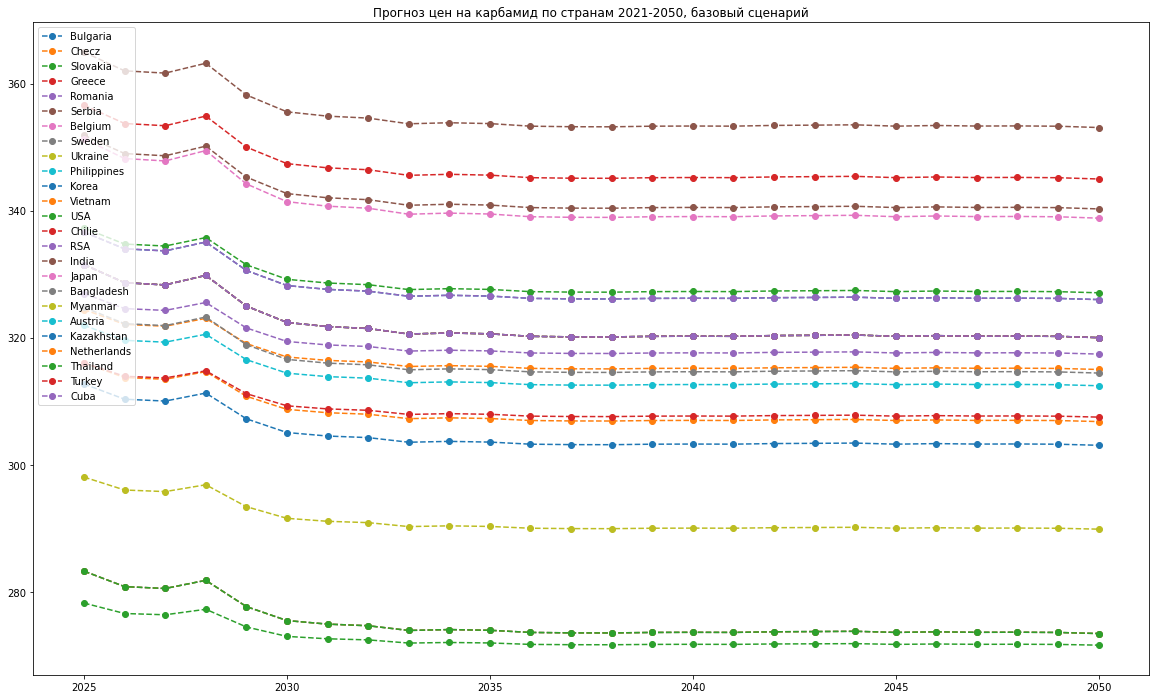

In [966]:
xs = forecast_horizon[4:]
plt.figure(figsize=(20, 12))
plt.title('Прогноз цен на карбамид по странам 2021-2050, базовый сценарий')

for country in final['base'].keys():
    plt.plot(xs, final['base'][country], label=country, linestyle='--', marker='o')

plt.legend(loc='upper left');

# Оценка инвестиционной привлекательности: NPV, IRR, PBP

Капитальные затраты - 1.530 млн. долл. США

In [848]:
capital_exp = 1530000000

Производительность завода, т/год

In [849]:
urea_annual = 1460000
ammonia_raw_annual = 1100000

__Для решения задачи выбора оптимального маршрута, решим уравнение:__


$$\frac{143}{66} \cdot x + 55000000 = \frac{294}{66} \cdot x,$$

где  x - количество тонн продукции, которое необходимо произвести, чтобы перевозка в порт Усть-Луга стала более выгодной, чем перевозка в порт Силламяэ,  143 и 294 - размеры тарифов в долларах США для обоих портов, 55 млн - капитальные затраты на расширение мощностей порта Усть-Луга  

Решением уравнения является:  $x = 2.40397 \cdot 10^7$ тонн

Известно, что для производства 1 тонны карбамида необходима 0.71 тонн аммиака. При условии, что для ЕвроХима приоритетным является производство карбамида, то количество ежегодно производимой конечной продукции, которая далее будет реализована по рыночной цене:

In [850]:
ammonia_annual = ammonia_raw_annual - 0.71 * urea_annual
total_annual = ammonia_annual + urea_annual
print(ammonia_annual, 'тонн аммиака в год')
print(urea_annual, 'тонн карбамида в год')
print(total_annual, 'всего тонн продукции в год')

63400.0 тонн аммиака в год
1460000 тонн карбамида в год
1523400.0 всего тонн продукции в год


In [851]:
round(2.40397 * 10 ** 7 / 1500000)

16

Таким образом, если завод будет работать в режиме проектных мощностей более 16 лет, то порт Усть-Луга при прочих равных обладает сравнительным примуществом по отношению к порту Силламяэ (меньшими постоянными и переменными издержками)

__Издержки завода__

Амортизация начисляется линейным способом в течение 26 лет, USD/год

In [928]:
Amort_annual = capital_exp / 26

Пошлины на ввоз в каждом регионе: на аммиак - 5.5%, на карбамид - 6.5% от цены

In [929]:
duty_urea = 0.065
duty_ammonia = 0.055

Налог на прибыль - 18%

In [930]:
income_tax = 0.18

Себестоимость производства аммиака - 139 USD/т, карбамида - 111 USD/т

In [931]:
urea_cost = 111
ammonia_cost = 139

Ставка дисконтирования - 11%

In [932]:
r = 0.11

Затраты на расширение мощностей порта Усть-Луга, распределенные на весь период

In [933]:
capacity_exp = 50000000

Затраты на логистику, USD/т:

In [934]:
tariff = 143 / 66
car_rental = 56 / 66
transshipment = 1.5
total_logistic = (tariff + car_rental + transshipment)
print(total_logistic, 'всего долларов на тонну на логистику')

4.515151515151516 всего долларов на тонну на логистику


При расчете размера фрахт использовалась предпосылка о том, что значение, приведенное в слайде рассчитывалось для 33 тонн груза (медианное значение)

In [935]:
braz_freicht = (40 + 60) * 0.5 / 33
china_freicht = (40 + 50) * 0.5 / 33
usa_freicht = (20 + 30) * 0.5 / 33
pol_freicht = (30 + 50) * 0.5 / 33

Условно-постоянные годовые административные расходы, USD/год

In [936]:
admin_exp_annual = 475000000 * 0.013

__Выручка завода__

In [937]:
ammonia_price = dict()
ammonia_price['base'] = base_ammonia[4:]
ammonia_price['good'] = good_ammonia[4:]
ammonia_price['bad'] = bad_ammonia[4:]

Согласно, географии продаж, экспортные потоки распределены: 

In [938]:
dict(zip(countries_list, country_share))

{'Bulgaria': 0.0036,
 'Checz': 0.0017,
 'Slovakia': 0.0012,
 'Greece': 0.0048,
 'Romania': 0.0113,
 'Serbia': 0.0174,
 'Belgium': 0.0086,
 'Sweden': 0.0066,
 'Ukraine': 0.0216,
 'Philippines': 0.0453,
 'Korea': 0.0473,
 'Vietnam': 0.0156,
 'USA': 0.1476,
 'Chilie': 0.0306,
 'RSA': 0.0148,
 'India': 0.3835,
 'Japan': 0.0247,
 'Bangladesh': 0.0797,
 'Myanmar': 0.0326,
 'Austria': 0.0054,
 'Kazakhstan': 0.0044,
 'Netherlands': 0.0072,
 'Thailand': 0.0552,
 'Turkey': 0.0089,
 'Cuba': 0.0205}

Посчитаем выручку завода для трех сценариев (взвешенная сумма * выпуск)

Взвешенная сумма:

In [939]:
weighted_sum = dict()

for sc in sc_list:
    count = country_share[0] * final[sc]['Bulgaria']
    for share, country in zip(country_share[1:], countries_list[1:]):
        count = count + share * final[sc][country]
    weighted_sum[sc] = count
    
    print('Взвешенная при {} сценарии:'.format(sc), weighted_sum[sc], sep='\n')
    print()

Взвешенная при base сценарии:
[331.14963156 328.5691776  328.25662159 329.61684109 325.24473953
 322.91780921 322.32440149 322.05676978 321.27024568 321.4157701
 321.29627635 320.94128811 320.86557707 320.8535739  320.93816162
 320.96200808 320.94436512 321.04602572 321.08415295 321.12797902
 320.94386508 321.03713181 320.95903191 320.97650627 320.93584737
 320.75428304]

Взвешенная при good сценарии:
[331.14963156 321.89333869 360.27362932 363.82865598 363.07053106
 359.47722007 375.80028142 378.05423117 374.92009566 383.21283524
 384.84002605 392.13933198 392.5301312  391.35289189 392.73551725
 391.71219308 392.77475374 396.13353897 396.56372919 397.68790685
 397.69387992 397.81405661 397.89665756 397.41800647 398.35471253
 398.86615374]

Взвешенная при bad сценарии:
[331.14963156 307.6468475  318.13890874 323.83284901 334.44597879
 331.09215337 326.57820449 315.87698174 309.09577237 315.05183971
 284.26778016 274.49483628 260.05472372 261.72414384 265.5292847
 263.06481925 255.43072

In [940]:
annual_duty = dict()
total_cost_annual = dict()

annual_total_logistic = total_logistic * 1500000 + 23400 * (294 / 66 + total_logistic - tariff) 
urea_cost_annual = urea_cost * urea_annual
ammonia_cost_annual = ammonia_cost * ammonia_annual

for sc in sc_list:
    
    annual_duty[sc] = 0.055 * weighted_sum[sc] + 0.55 * ammonia_annual * ammonia_price[sc]
    total_cost_annual[sc] = annual_duty[sc] + annual_total_logistic \
    + urea_cost_annual + ammonia_cost_annual + Amort_annual + admin_exp_annual
    
    print('Ежегодная совокупные издержки при {} сценарии:'.format(sc), income[sc], sep='\n')
    print()

Ежегодная совокупные издержки при base сценарии:
[5.00216062e+08 4.97278784e+08 4.96867110e+08 4.98360492e+08
 4.92111058e+08 4.88724143e+08 4.87621955e+08 4.87396821e+08
 4.85807816e+08 4.86102237e+08 4.86204320e+08 4.85238345e+08
 4.85240074e+08 4.85373937e+08 4.85610947e+08 4.85738187e+08
 4.85205596e+08 4.85727949e+08 4.85941134e+08 4.85645396e+08
 4.85727933e+08 4.85305084e+08 4.86065213e+08 4.85613662e+08
 4.85618203e+08 4.85457333e+08]

Ежегодная совокупные издержки при good сценарии:
[5.00216062e+08 4.87360745e+08 5.45415861e+08 5.51051291e+08
 5.49169137e+08 5.43863447e+08 5.69163086e+08 5.72377152e+08
 5.67988211e+08 5.80153521e+08 5.82288428e+08 5.93488971e+08
 5.94170346e+08 5.92670588e+08 5.95052498e+08 5.93473634e+08
 5.94635882e+08 5.99778524e+08 6.00149848e+08 6.02161189e+08
 6.01993734e+08 6.02586223e+08 6.02282439e+08 6.01421538e+08
 6.03368940e+08 6.03948160e+08]

Ежегодная совокупные издержки при bad сценарии:
[5.00216062e+08 4.65625816e+08 4.81652098e+08 4.89757623

In [941]:
income = dict()

for sc in sc_list:
    income[sc] = urea_annual * weighted_sum[sc] + ammonia_annual * ammonia_price[sc]
    
    print('Ежегодная выручка при {} сценарии:'.format(sc), income[sc], sep='\n')
    print()

Ежегодная выручка при base сценарии:
[5.00216062e+08 4.97278784e+08 4.96867110e+08 4.98360492e+08
 4.92111058e+08 4.88724143e+08 4.87621955e+08 4.87396821e+08
 4.85807816e+08 4.86102237e+08 4.86204320e+08 4.85238345e+08
 4.85240074e+08 4.85373937e+08 4.85610947e+08 4.85738187e+08
 4.85205596e+08 4.85727949e+08 4.85941134e+08 4.85645396e+08
 4.85727933e+08 4.85305084e+08 4.86065213e+08 4.85613662e+08
 4.85618203e+08 4.85457333e+08]

Ежегодная выручка при good сценарии:
[5.00216062e+08 4.87360745e+08 5.45415861e+08 5.51051291e+08
 5.49169137e+08 5.43863447e+08 5.69163086e+08 5.72377152e+08
 5.67988211e+08 5.80153521e+08 5.82288428e+08 5.93488971e+08
 5.94170346e+08 5.92670588e+08 5.95052498e+08 5.93473634e+08
 5.94635882e+08 5.99778524e+08 6.00149848e+08 6.02161189e+08
 6.01993734e+08 6.02586223e+08 6.02282439e+08 6.01421538e+08
 6.03368940e+08 6.03948160e+08]

Ежегодная выручка при bad сценарии:
[5.00216062e+08 4.65625816e+08 4.81652098e+08 4.89757623e+08
 5.06283141e+08 5.00989465e+08 

In [942]:
net_profit = dict()

for sc in sc_list:
    net_profit[sc] = income[sc] - total_cost_annual[sc]
    
    print('Ежегодная чистая прибыль при {} сценарии:'.format(sc), net_profit[sc], sep='\n')
    print()

Ежегодная чистая прибыль при base сценарии:
[2.48184692e+08 2.44790812e+08 2.44354576e+08 2.46118855e+08
 2.39795812e+08 2.36403176e+08 2.35430685e+08 2.35114466e+08
 2.33767835e+08 2.34017180e+08 2.33967164e+08 2.33247420e+08
 2.33187402e+08 2.33238002e+08 2.33412580e+08 2.33488987e+08
 2.33235154e+08 2.33551846e+08 2.33678395e+08 2.33580506e+08
 2.33469804e+08 2.33354415e+08 2.33633759e+08 2.33444593e+08
 2.33413987e+08 2.33195799e+08]

Ежегодная чистая прибыль при good сценарии:
[2.48184692e+08 2.34966997e+08 2.91911170e+08 2.97301800e+08
 2.95846056e+08 2.90573067e+08 3.15065322e+08 3.18321573e+08
 3.13829839e+08 3.25963298e+08 3.28230640e+08 3.39132227e+08
 3.39752658e+08 3.38132443e+08 3.40314551e+08 3.38782333e+08
 3.40158580e+08 3.45169874e+08 3.45682412e+08 3.47490230e+08
 3.47419672e+08 3.47782794e+08 3.47712420e+08 3.46940657e+08
 3.48569163e+08 3.49240500e+08]

Ежегодная чистая прибыль при bad сценарии:
[2.48184692e+08 2.13746347e+08 2.29383298e+08 2.37603018e+08
 2.5356184

__Расчет NPV__

In [943]:
npv = dict()

for sc in sc_list:
    npv[sc] = -(capital_exp + capacity_exp)
    for period in range(26):
        npv[sc] = npv[sc] + net_profit[sc][period] * (1 - income_tax) / (1 + r) ** (period + 1)
    
    print('NPV при {} сценарии:'.format(sc), npv[sc], sep='\n')
    print()

NPV при base сценарии:
82701616.82936841

NPV при good сценарии:
525330209.79339933

NPV при bad сценарии:
-140845934.58630696



__Посмотрим, где функция NPV для трех сценариев меняет знак и найдем приблизительные значения IRR__

In [926]:
irr_base = 0.117
irr_good = 0.149
irr_bad = 0.095

__Вычислим срок PBP (срок окупаемости проекта)__

In [964]:
pbp = dict()

for sc in sc_list:
    balance = -(capital_exp + capacity_exp)
    pbp[sc] = 0
    while balance < 0:
        balance = balance + (income[sc][pbp[sc]] - total_cost_annual[sc][pbp[sc]]) * (1 - income_tax) / (1 + r) ** (pbp[sc] + 1)
        pbp[sc] += 1
    
    print('PBP при {} сценарии:'.format(sc), pbp[sc], sep='\n')
    print()

PBP при base сценарии:
16

PBP при good сценарии:
12

PBP при bad сценарии:
26

